In [1]:
render = 0

In [2]:
import os
directory = '../../output.tara-delmont'
render='svg'
name=os.path.basename(directory)

In [3]:
if not render: render_name = None
else: render_name = render

In [4]:
from charcoal.utils import load_contamination_summary, build_contamination_matrix, filter_contam

import plotly.graph_objects as go

In [5]:
# load contamination summary from given directory!
with open(f'{directory}/contam_summary.json', 'rt') as fp:
    source_d = load_contamination_summary(fp)

In [6]:
# do sorting and filtering
THRESHOLD_F=0.8
sub_list = filter_contam(source_d, THRESHOLD_F)
source_labels, target_labels, mat_l = build_contamination_matrix(sub_list)

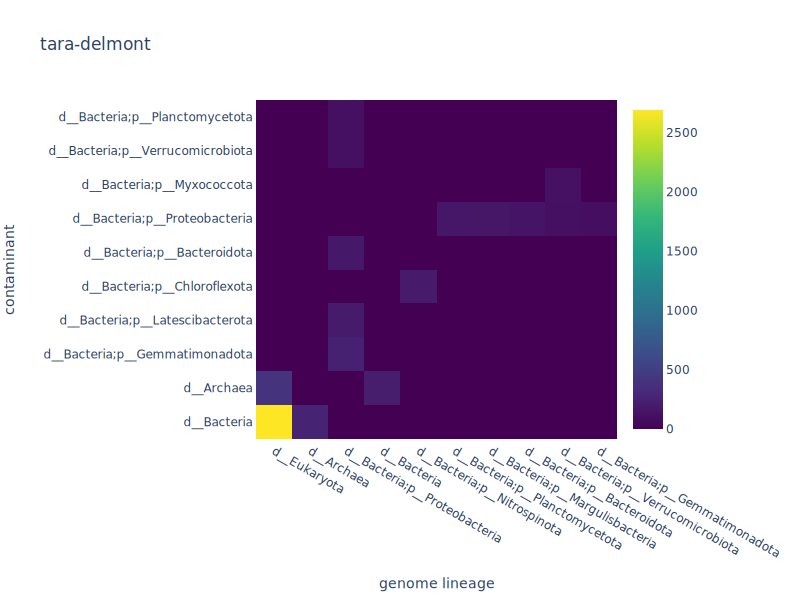

In [7]:
# make actual plot!
fig = go.Figure(data=go.Heatmap(
                   z=mat_l,
                   x=source_labels,
                   y=target_labels,
                   hoverongaps = False,
                   colorscale="Viridis"))
fig.update_layout(xaxis_title='genome lineage', yaxis_title='contaminant',
                  title=f'{name[7:]}')
fig.show(render_name, width=800, height=600)